### Aleksandr Belov
### Stochastic analysis homework 2.6
#### 6 November 2019

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", color_codes=True)

In [2]:
p = 100
b = 0.1
d = 10


def second(x):
    return x[1] + b*x[0]**2 - p*b


def U(x):
    assert len(x) == d
    return x[0]**2/2/p + second(x)**2 + (x[3:]**2).sum()/2


def grad_U(x):
    assert len(x) == d
    grad = x.copy()
    grad[0] = x[0]/p + 4*x[0]*b*second(x)
    grad[1] = 2*second(x)
    
    return grad


def task_dist(x):
    return np.exp(-U(x))

# Implementation of algorithms

In [3]:
def MALA(x0, dist, h=0.1, n_samples=100):
    shape = x0.shape[0]
    samples = np.zeros((n_samples+1, shape))
    samples[0] = x0
    x = x0
                        
    l_cur = dist(x)
    u = np.random.rand(n_samples)
    grud_cur = grad_U(x)
    acceptances = np.zeros(n_samples)

    for i in range(n_samples):
        cand = np.random.multivariate_normal(samples[i] - h*grud_cur, 2*h*np.eye(shape))
        l_cand = dist(cand)
        acceptances[i] = min(l_cand / l_cur, 1)

        if acceptances[i] > u[i]:
            x = cand
            l_cur = l_cand
            grud_cur = grad_U(x)

        samples[i+1] = x

    return samples, acceptances


def RWMA(x0, dist, sigma=1, n_samples=100, prop_dist='norm'):
    shape = x0.shape[0]
    samples = np.zeros((n_samples+1, shape))
    samples[0] = x0
    x = x0
                        
    l_cur = dist(x)
    u = np.random.rand(n_samples)
    if prop_dist == 'norm':
        z = np.random.normal(0, sigma, (n_samples, shape))
    elif prop_dist == 'laplace':
        z = np.random.laplace(0, sigma, (n_samples, shape))
    elif prop_dist == 'uni':
        z = np.random.uniform(-sigma, sigma, (n_samples, shape))
    else:
        raise ValueError
    acceptances = np.zeros(n_samples)
    
    for i in range(n_samples):
        cand = x + z[i]
        l_cand = dist(cand)
        acceptances[i] = min(l_cand / l_cur, 1)

        if acceptances[i] > u[i]:
            x = cand
            l_cur = l_cand

        samples[i+1] = x

    return samples, acceptances

In [4]:
x0 = np.random.rand(d)
steps = [10**i for i in range(-6, 3)]

# MALA

h=1e-05, X2 mean: 4.421293735711161


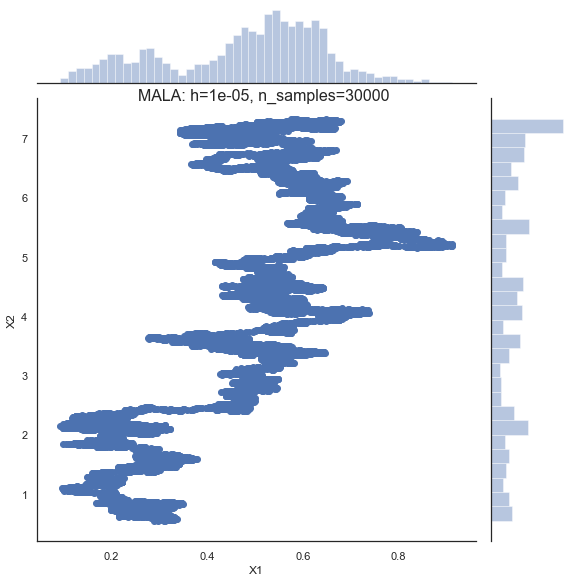

h=0.001, X2 mean: 9.503600846124785


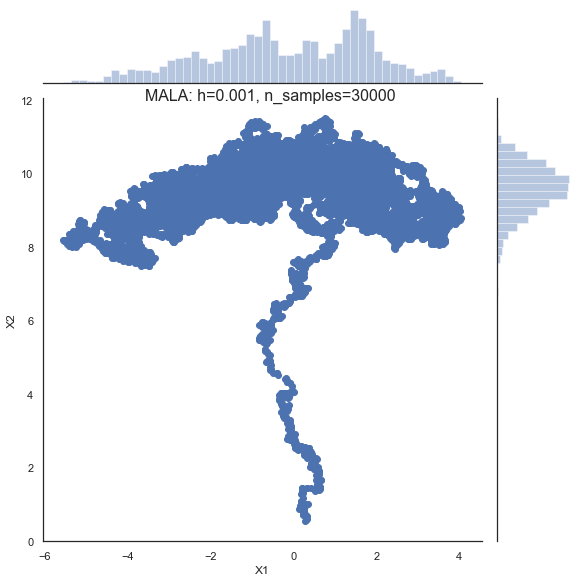

h=0.1, X2 mean: 8.021087470736102


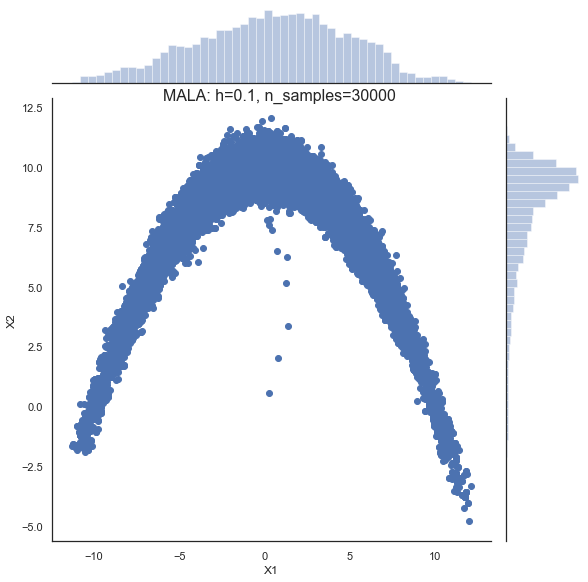

h=10, X2 mean: 0.5525031082477928


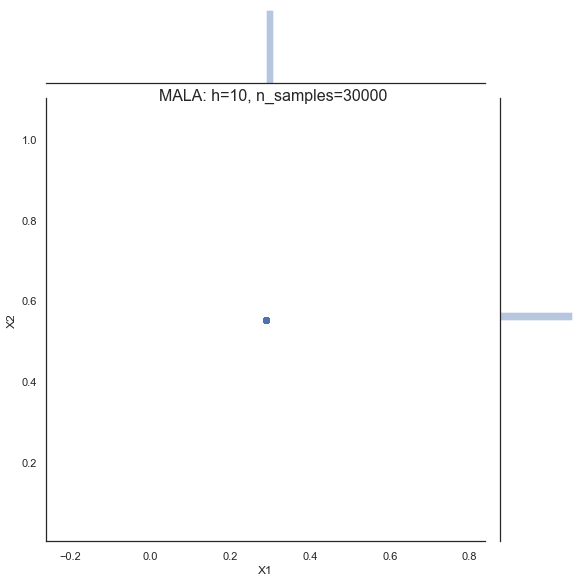

In [5]:
n_samples = 30000

results_MALA = {}
acceptances_MALA = {}

for h in steps:
    result_MALA, acceptance_MALA = MALA(x0, task_dist, h=h, n_samples=n_samples)
    results_MALA[h] = result_MALA
    acceptances_MALA[h] = acceptance_MALA
    
for h in steps[1::2]:
    print(f'h={h}, X2 mean: {results_MALA[h][:, 1].mean()}')
    g = sns.jointplot(x=results_MALA[h][:, 0], y=results_MALA[h][:, 1], height=8).set_axis_labels('X1', 'X2')
    plt.title(f'MALA: h={h}, n_samples={n_samples}', fontsize=16, x=-3, pad=-2)
    plt.show()

### Average ratio in MALA

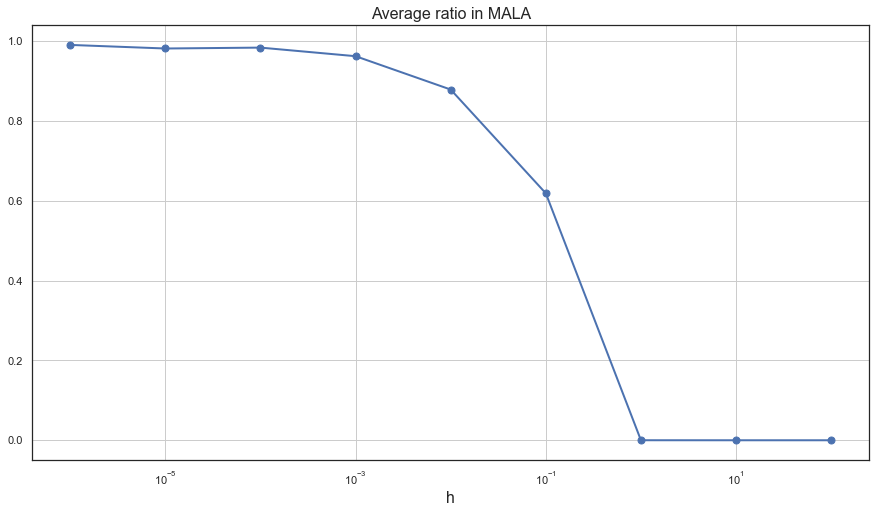

In [6]:
aa = [acceptances_MALA[h].mean() for h in steps]

plt.figure(figsize=(15, 8))
plt.plot(steps, aa, 'o-', linewidth=2, markersize=7)
plt.xscale('log')
plt.xlabel('h', fontsize=16)
plt.title('Average ratio in MALA', fontsize=16)
plt.grid()

### Estimation of $\mathbb{E} X_2$

In [7]:
n_tests = 10
h = 0.1
n_samples = 10000
est = np.zeros(n_tests)

for i in range(n_tests):
    result_MALA, _ = MALA(x0, task_dist, h=h, n_samples=n_samples)
    est[i] = result_MALA[:, 1].mean()

In [8]:
for i in range(n_tests):
    print(f'Test {i+1}: {est[i]}')
print(f'\nMean of tests: {est.mean()}')

Test 1: 8.42801921681164
Test 2: 7.8460147257409805
Test 3: 6.4862597391465435
Test 4: 8.24111992949094
Test 5: 7.7743625271991466
Test 6: 6.779674216207216
Test 7: 2.716470962229113
Test 8: 6.522918166486641
Test 9: 7.849343441549801
Test 10: 7.531613998115193

Mean of tests: 7.017579692297721


# Random-Walk

X2 mean: 2.347855720290572


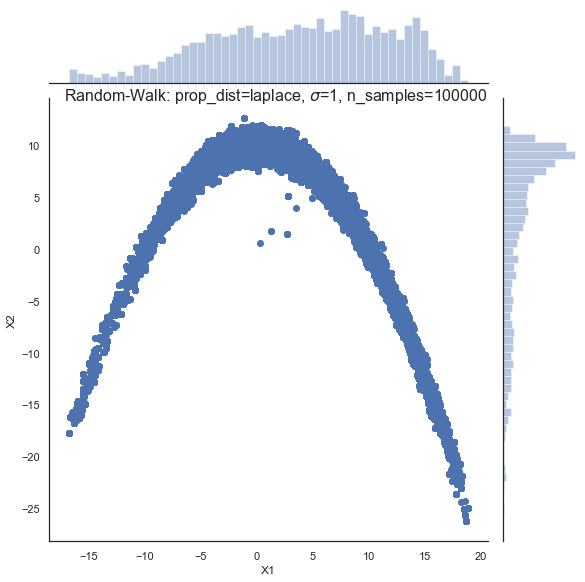

In [14]:
n_samples = 100000
sigma = 1
prop_dist = 'laplace'
result_RWMA, _ = RWMA(x0, task_dist, n_samples=n_samples, prop_dist=prop_dist, sigma=sigma)

print(f'X2 mean: {result_RWMA[:, 1].mean()}')
g = sns.jointplot(x=result_RWMA[:, 0], y=result_RWMA[:, 1], height=8).set_axis_labels('X1', 'X2')
plt.title(fr'Random-Walk: prop_dist={prop_dist}, $\sigma$={sigma}, n_samples={n_samples}', fontsize=16, x=-3, pad=-2)
plt.show()

sigma=0.001, X2 mean: 0.7128398769226368


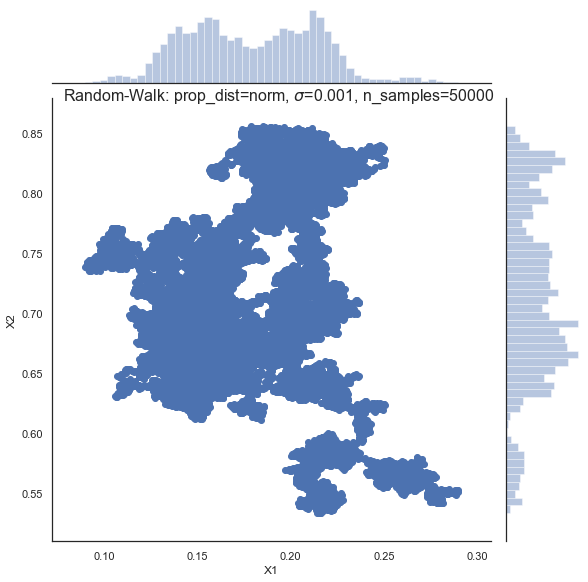

sigma=0.01, X2 mean: 6.473934229133452


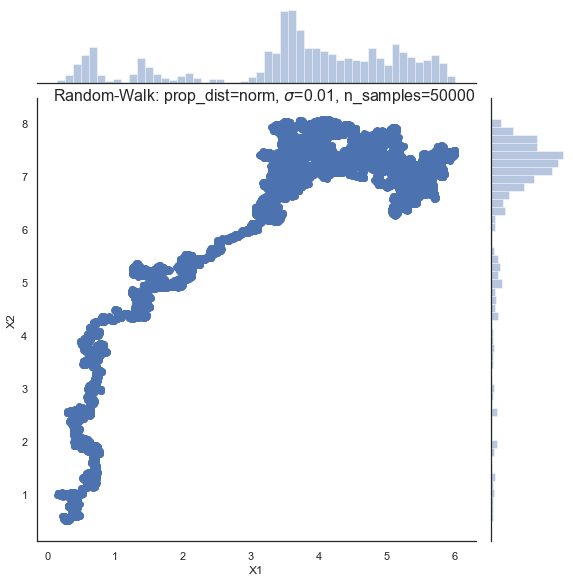

sigma=0.1, X2 mean: 8.479434868426937


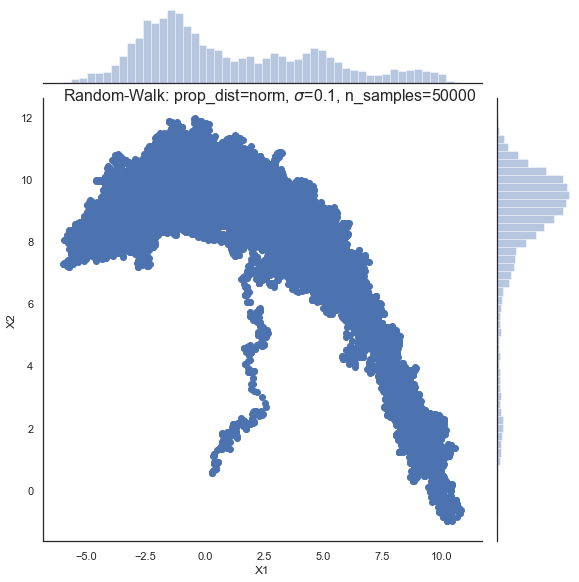

sigma=1, X2 mean: 1.0145122604588923


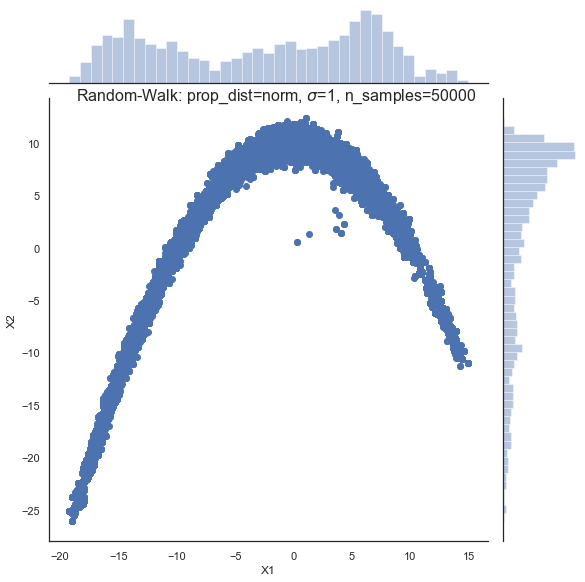

sigma=1.5, X2 mean: 6.225170501929764


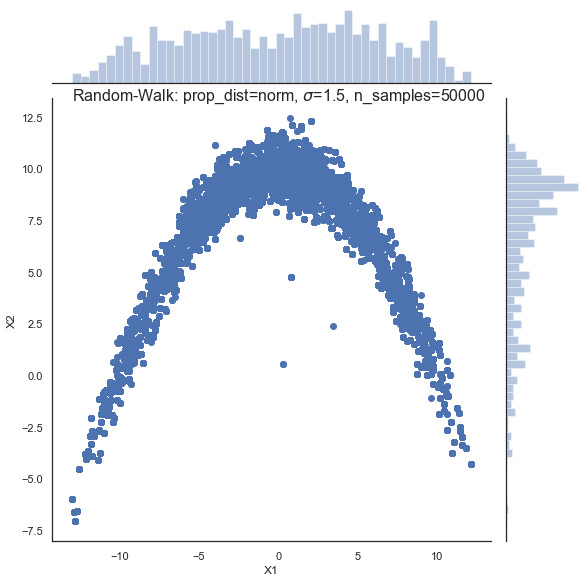

sigma=10, X2 mean: 3.2463637797715648


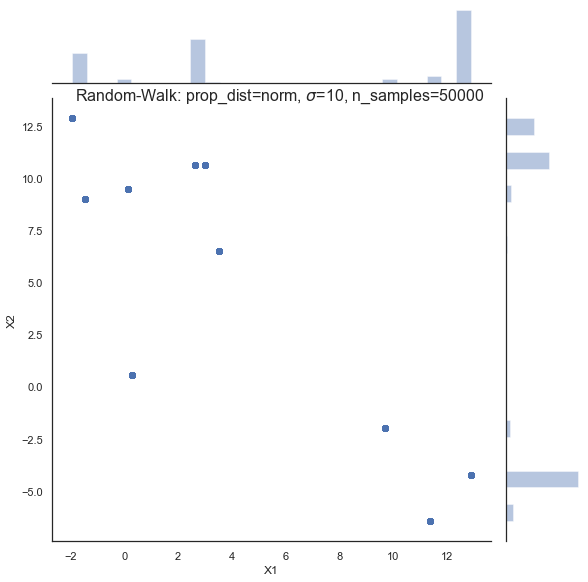

In [10]:
n_samples = 50000
sigmas = [10**i for i in range(-3, 3)]
sigmas[-2] = 1.5
sigmas[-1] = 10
prop_dist = 'norm'

results_RWMA = {}
acceptances_RWMA = {}

for sigma in sigmas:
    result_RWMA, acceptance_RWMA = RWMA(x0, task_dist, n_samples=n_samples, prop_dist=prop_dist, sigma=sigma)
    results_RWMA[sigma] = result_RWMA
    acceptances_RWMA[sigma] = acceptance_RWMA
    
for sigma in sigmas:
    print(f'sigma={sigma}, X2 mean: {results_RWMA[sigma][:, 1].mean()}')
    g = sns.jointplot(x=results_RWMA[sigma][:, 0], y=results_RWMA[sigma][:, 1], height=8).set_axis_labels('X1', 'X2')
    plt.title(fr'Random-Walk: prop_dist={prop_dist}, $\sigma$={sigma}, n_samples={n_samples}', fontsize=16, x=-3, pad=-2)
    plt.show()

### Average ratio in MALA

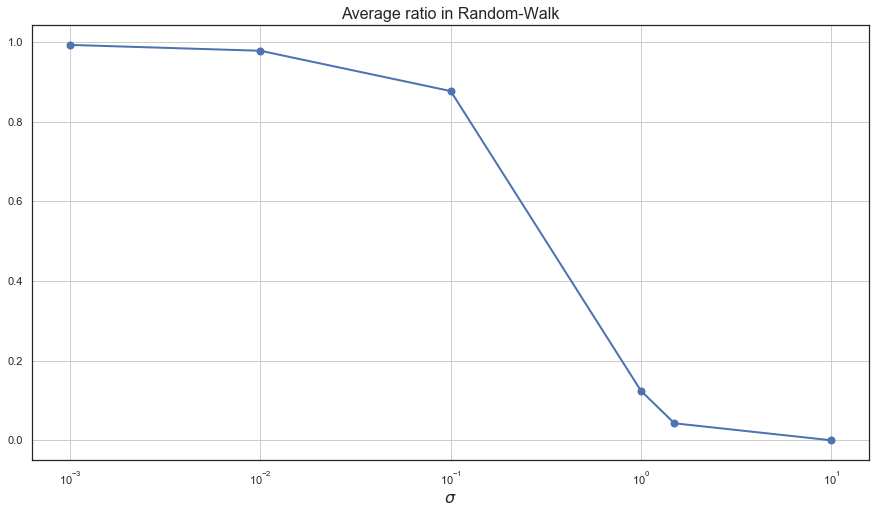

In [11]:
aa = [acceptances_RWMA[s].mean() for s in sigmas]

plt.figure(figsize=(15, 8))
plt.plot(sigmas, aa, 'o-', linewidth=2, markersize=7)
plt.xscale('log')
plt.xlabel(r'$\sigma$', fontsize=16)
plt.title('Average ratio in Random-Walk', fontsize=16)
plt.grid()

### Estimation of $\mathbb{E} X_2$

In [12]:
n_tests = 10
n_samples = 10000
sigma = 1

est = np.zeros(n_tests)

for i in range(n_tests):
    result_RWMA, _ = RWMA(x0, task_dist, n_samples=n_samples, sigma=sigma)
    est[i] = result_RWMA[:, 1].mean()

In [13]:
for i in range(n_tests):
    print(f'Test {i+1}: {est[i]}')
print(f'\nMean of tests: {est.mean()}')

Test 1: -24.107631151753278
Test 2: 3.1460762954652974
Test 3: 4.482876317184202
Test 4: 7.734044909844185
Test 5: 3.0725097717729395
Test 6: 5.471570184483652
Test 7: 4.99644055473475
Test 8: 7.270136671480815
Test 9: 6.606468026394482
Test 10: 5.361996460980877

Mean of tests: 2.4034488040587916
